# Figure 4

Corresponds to Section 3 of the results, regarding interpretable treatment strategies

In [1]:
import os
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import to_rgb

sys.path.append("../utils")
from myUtils import convert_ode_parameters, obtain_architecture
from plotUtils import plot_simulation

/home/gallagher/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Defaults for plotting
plt.style.use(["classic", "./paper.mplstyle"])
plt.rcParams['font.size'] = '18'

colors = {'Sensitive': '#4c9150', 'Resistant': '#a80303', 'CT':'#c28d32' , 'AT':'#143159' ,'DRL_Monthly':'#66419e'}

In [3]:
def convert_to_rgb_grayscale(col):
    rgb_col = to_rgb(col)
    return tuple([(0.2989 * rgb_col[0]) + (0.5870 * rgb_col[1]) + (0.1140 * rgb_col[2]) for _ in range(3)])

def redistribute_rgb(col):
    r, g, b = col
    threshold = 1 
    m = max(r, g, b)
    if m <= threshold:
        return r, g, b
    total = r + g + b
    if total >= 3 * threshold:
        return threshold, threshold, threshold
    x = (3 * threshold - total) / (3 * m - total)
    gray = threshold - x * m
    return (gray + x * r), (gray + x * g), (gray + x * b)

/tmp/ipykernel_27043/2990576886.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([''] + list(colors.keys()));


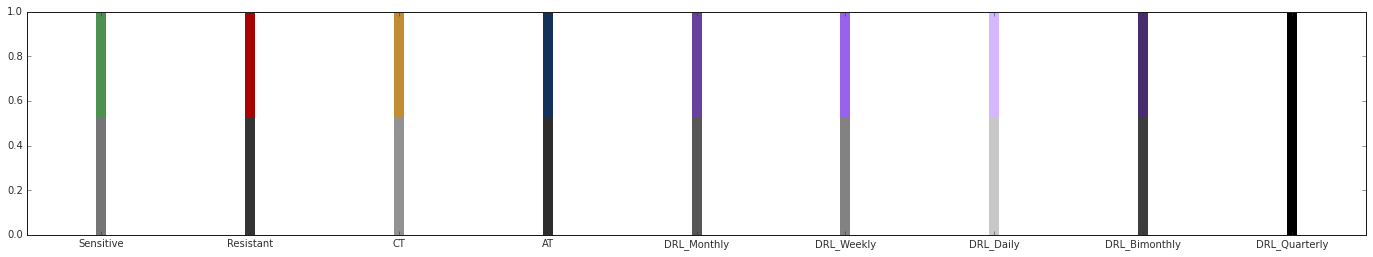

In [4]:
# Defaults for plotting
plt.style.use(["classic", "./paper.mplstyle"])

colors = {'Sensitive': '#4c9150', 'Resistant': '#a80303', 'CT':'#c28d32' , 'AT':'#143159' ,'DRL_Monthly':'#66419e'}

colors['DRL_Weekly'] = redistribute_rgb(tuple([1.5 * x for x in to_rgb(colors['DRL_Monthly'])]))
colors['DRL_Daily'] = redistribute_rgb(tuple([2.0 * x for x in to_rgb(colors['DRL_Monthly'])]))

colors['DRL_Bimonthly'] = redistribute_rgb(tuple([0.7 * x for x in to_rgb(colors['DRL_Monthly'])]))
colors['DRL_Quarterly'] = redistribute_rgb(tuple([0 * x for x in to_rgb(colors['DRL_Monthly'])]))

fig, ax = plt.subplots(1, 1, figsize=(24, 4))
for i, col in enumerate(colors.values()):
    plt.axvline(i+1, 0.5, 1, color = col, linewidth=10)
    plt.axvline(i+1, 0, 0.5, color = convert_to_rgb_grayscale(col), linewidth=10)
plt.xlim(0.5, len(colors.values()) + 0.5)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().set_xticklabels([''] + list(colors.keys()));

## Panel A - Basic Sigmoid learnt over monthly treatment

In [5]:
# Notebook params
file_path = os.path.dirname(os.path.abspath("__file__"))
model_path = os.path.join(os.pardir, file_path, "models")
results_path = os.path.join(file_path, "data", "Fig3")
runFromScratch = True

model_name = 'TueApr261403442022'; n_epochs = 115600
model_name = 'test_currSizeOnly_pCR_monthly'; n_epochs = 140000
n_replicates = 100

odeParamDic = convert_ode_parameters(n0=0.75, rFrac=0.001, cost=0, turnover=0)
odeParamDic['K'] = odeParamDic['k']

In [6]:
print(odeParamDic)

{'n0': 0.75, 'rS': 0.027, 'rR': 0.027, 'dS': 0.0, 'dR': 0.0, 'dD': 1.5, 'k': 1.0, 'D': 0, 'theta': 1, 'DMax': 1.0, 'S0': 0.74925, 'R0': 0.00075, 'cost': 0, 'turnover': 0, 'K': 1.0}


In [7]:
DRL_env = "/Users/galla/miniconda3/envs/DRL_env_tf15/python"  # Laptop
DRL_env = "/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python"  # Desktop

updating_interval=7

currModel_path = os.path.join(os.pardir,"models",model_name, "%d_patients_%s"%(n_epochs, model_name))
results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%d.csv'%(model_name,n_epochs, updating_interval)
argDic = {'model_path':currModel_path, 'patients_to_evaluate':pd.DataFrame([{**odeParamDic,'PatientId':0}]).to_dict(),
          'architecture_kws':obtain_architecture(model_name),
          'n_replicates':n_replicates, 'updating_interval':updating_interval,
          'results_path':results_path, 'results_file_name':results_file_name, 'seed':43,
          'verbose':0, 'tqdm_output':os.path.join(results_path,"log_currentSizeOnly_baseCase.txt")}
# To run the DRL we need tensorflow 1.5 which is not compatible with Python >3.6. To be able 
# to run it I made a separate environment. Use an external script to run the evaluation in that
# environment.
if runFromScratch:
    param_dir = os.path.join(file_path, "data", "Fig3", "params", "params_pCR_%s_%s.json"%(n_epochs, updating_interval))
    with open(param_dir, "w") as outfile:
        json.dump(argDic, outfile)
        print("Printed to JSON")
    command = DRL_env + " run_evaluation.py ../paper_figures/data/Fig3/params/params_pCR_%s_%s.json"%(n_epochs, updating_interval)
    # p = subprocess.run(command, capture_output=True, shell=True)
    print(command)

    # Load results and process them
    dataDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
    # Extract TTP information
    tmpList = []
    for replicateId in dataDf_currSizeOnly_step1.ReplicateId.unique():
        ttp = dataDf_currSizeOnly_step1[dataDf_currSizeOnly_step1.ReplicateId==replicateId].Time.max()
        tmpList.append({"Model":"currSizeOnly_step1", "ReplicateId":replicateId, "TTP":ttp})
    ttpDf_currSizeOnly_step1 = pd.DataFrame(tmpList)
    ttpDf_currSizeOnly_step1.to_csv(os.path.join(results_path,"ttpDf_%s_crBase_%d_patients_int_%d.csv"%(model_name,n_epochs, updating_interval)))
else:
    # Load results
    dataDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
    ttpDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,"ttpDf_%s_crBase%d_patients_int_%d.csv"%(model_name,n_epochs, updating_interval)), index_col=0)
        
# For these historical models (daily and weekly), we need to adapt evaluation code so that normalisation is not used. This is L473 of drlUtils.py (in run_evaluation())
# We also change ODE evaluation interval (removing argument in L427) so info with the same interval is fed in)

Printed to JSON
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig3/params/params_pCR_140000_7.json


In [8]:
results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%s.csv'%(model_name,n_epochs, updating_interval)
policyDf = pd.read_csv(os.path.join(results_path,results_file_name))
policyDf['TumourSize'] /= policyDf['TumourSize'].iloc[0]

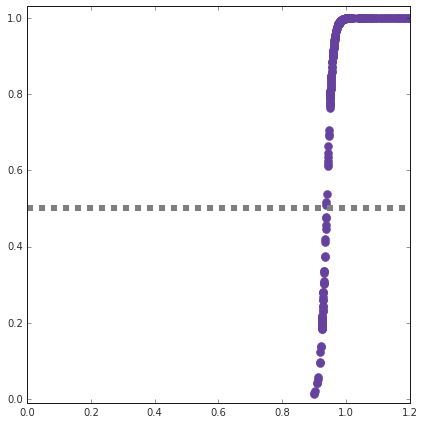

In [9]:
# Plot learned policies
fix, ax = plt.subplots(1,1,figsize=(6,6))
plot_df = policyDf[policyDf['ReplicateId'] < 2]
ax.plot(plot_df['TumourSize'], plot_df['Support_Treat'], linestyle = '', marker = '.', markersize=16, color=colors['DRL_Monthly'])
# ax.scatter(plot_df['TumourSize'], plot_df['Support_Treat'], c=plot_df.Time)
# plt.xticks(np.arange(0.8, 1.3, step=0.1))
ax.set_ylim(-0.01,1.03); ax.set_xlim(0.0, 1.2);
ax.hlines(xmin=0, xmax=1.2, y=0.5, linestyles="--", linewidth=6, color='gray')
plt.tight_layout(); plt.savefig("figures/fig3a_monthly_strat.pdf")

## Panel B - Comparing the strategy for different evaluation frequencies

In [10]:
DRL_env = "/Users/galla/miniconda3/envs/DRL_env_tf15/python"  # Laptop
DRL_env = "/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python"  # Desktop

# models = {1: ('ThuMar311244502022', 2600), 7:('MonApr251644332022', 21300), 28:('TueApr261403442022', 115600)}
models = {30:('test_currSizeOnly_pCR_monthly', 140000), 60:('test_currSizeOnly_pCR_bimonthly', 100000), 100:('test_currSizeOnly_pCR_quarterly', 100000)}


results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%d.csv'%(model_name,n_epochs, updating_interval)
for updating_interval, model in models.items():
    updating_interval = 7 # Optional to increase resolution
    model_name, n_epochs = model
    currModel_path = os.path.join(os.pardir,"models",model_name, "%d_patients_%s"%(n_epochs, model_name))
    results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%d.csv'%(model_name,n_epochs, updating_interval)
    argDic = {'model_path':currModel_path, 'patients_to_evaluate':pd.DataFrame([{**odeParamDic,'PatientId':0}]).to_dict(),
              'architecture_kws':obtain_architecture(model_name),
              'n_replicates':n_replicates, 'updating_interval':updating_interval,
              'results_path':results_path, 'results_file_name':results_file_name, 'seed':43,
              'verbose':0, 'tqdm_output':os.path.join(results_path,"log_currentSizeOnly_baseCase.txt")}
    # To run the DRL we need tensorflow 1.5 which is not compatible with Python >3.6. To be able 
    # to run it I made a separate environment. Use an external script to run the evaluation in that
    # environment.
    if runFromScratch:
        param_dir = os.path.join(file_path, "data", "Fig2", "params", "params_pCR_%s_%s_%s.json"%(model_name, n_epochs, updating_interval))
        with open(param_dir, "w") as outfile:
            json.dump(argDic, outfile)
            print("Printed to JSON")
        command = DRL_env + " run_evaluation.py ../paper_figures/data/Fig2/params/params_pCR_%s_%s_%s.json"%(model_name, n_epochs, updating_interval)
        # p = subprocess.run(command, capture_output=True, shell=True)
        print(command)

        # Load results and process them
        dataDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
        # Extract TTP information
        tmpList = []
        for replicateId in dataDf_currSizeOnly_step1.ReplicateId.unique():
            ttp = dataDf_currSizeOnly_step1[dataDf_currSizeOnly_step1.ReplicateId==replicateId].Time.max()
            tmpList.append({"Model":"currSizeOnly_step1", "ReplicateId":replicateId, "TTP":ttp})
        ttpDf_currSizeOnly_step1 = pd.DataFrame(tmpList)
        ttpDf_currSizeOnly_step1.to_csv(os.path.join(results_path,"ttpDf_%s_crBase_%d_patients_int_%d.csv"%(model_name,n_epochs, updating_interval)))
    else:
        # Load results
        dataDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,results_file_name), index_col=0)
        ttpDf_currSizeOnly_step1 = pd.read_csv(os.path.join(results_path,"ttpDf_%s_crBase%d_patients_int_%d.csv"%(model_name,n_epochs, updating_interval)), index_col=0)
        
# For these historical models (daily and weekly), we need to adapt evaluation code so that normalisation is not used. This is L473 of drlUtils.py (in run_evaluation())
# We also change ODE evaluation interval (removing argument in L427) so info with the same interval is fed in)

Printed to JSON
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig2/params/params_pCR_test_currSizeOnly_pCR_monthly_140000_7.json
Printed to JSON
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig2/params/params_pCR_test_currSizeOnly_pCR_bimonthly_100000_7.json
Printed to JSON
/home/gallagher/miniconda3/envs/DRL_env_tf15/bin/python run_evaluation.py ../paper_figures/data/Fig2/params/params_pCR_test_currSizeOnly_pCR_quarterly_100000_7.json


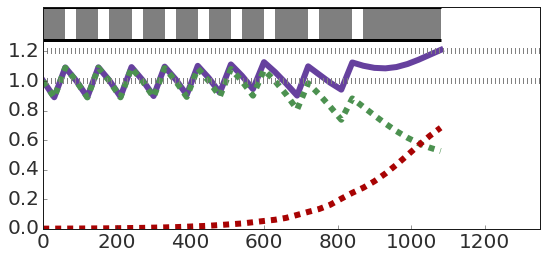

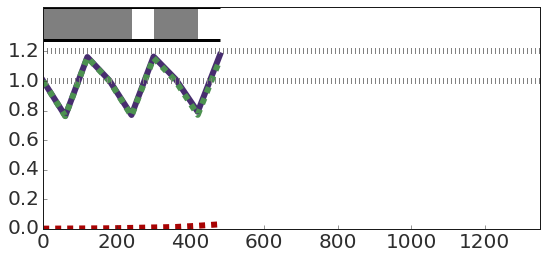

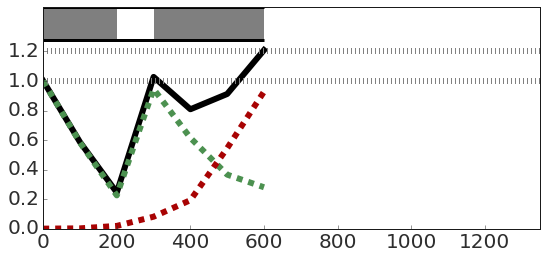

In [11]:
plt.rcParams['font.size'] = '20'

time_interals = {30:'Monthly', 60:'Bimonthly', 100:'Quarterly', 7:'Weekly'}
for updating_interval, model in models.items():
    # updating_interval = 7 # Optional to increase resolution
    model_name, n_epochs = model
    results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%d.csv'%(model_name,n_epochs, updating_interval)
    currDataDf = pd.read_csv(os.path.join(results_path,results_file_name))
    for col in ['TumourSize', 'S', 'R']:  # Normalise these columns
        currDataDf[col] /= odeParamDic['n0']
    # Plot example trajectories
    fix, ax = plt.subplots(1,1,figsize=(8,4))
    palette = {"TumourSize": colors["DRL_" + time_interals[updating_interval]], "S": colors["Sensitive"], "R": colors["Resistant"]}
    plot_simulation(currDataDf[currDataDf.ReplicateId == 2], plotPops=True, lineplot_kws={'estimator':None, 'units':"ReplicateId", 'lw': 6, 'palette': palette},
                    decorateAxes=False, decoratey2=False ,markInitialSize=True, markProgression=True, ylim=[0,1.5], xlim=[0, 1350], ax=ax)
    
    ax.yaxis.get_major_ticks()[-2].set_visible(False); ax.tick_params(right = False, top = False)

In [12]:
tmpList = []
for updating_interval, model in models.items():
    updating_interval = 7 # Optional to increase resolution
    model_name, n_epochs = model
    results_file_name = 'resultsDf_%s_crBase_%d_patients_int_%d.csv'%(model_name,n_epochs, updating_interval)
    currDataDf = pd.read_csv(os.path.join(results_path,results_file_name))
    currDataDf['TumourSize'] /= currDataDf['TumourSize'].iloc[0]
    currDataDf['UpdatingInterval'] = updating_interval
    currDataDf['Model'] = model_name
    tmpList.append(currDataDf)
policyDf = pd.concat(tmpList)

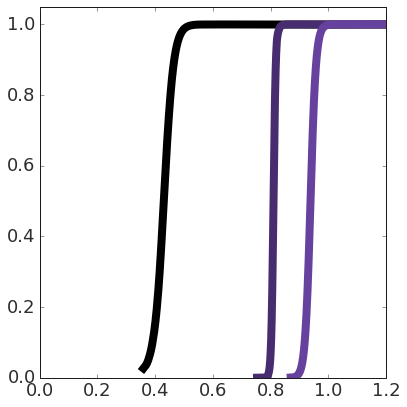

In [13]:
plt.rcParams['font.size'] = '18'
fig, ax = plt.subplots(1,1,figsize=(6, 6))
for updating_interval, model in models.items():
    df = policyDf[policyDf['Model'] == model[0]].sort_values('TumourSize')
    # df = df[df['ReplicateId'] < 20]
    ax.plot(df['TumourSize'], df['Support_Treat'], linestyle = '-', linewidth=8, zorder=(150-updating_interval), color = colors["DRL_" + time_interals[updating_interval]])
ax.set_ylim(0,1.05); ax.set_xlim(0, 1.2); plt.tight_layout()
plt.savefig("figures/fig3b_treatment_frequency_comp.pdf")